In [1]:
include("F:/Tue/Master/Thesis/codes/GP_CVI/BayesianUtilities-main/BayesianUtilities-main/BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities, Zygote
using DataStructures: Queue, enqueue!, dequeue!
using Flux.Optimise
using CSV, DataFrames, JLD

In [2]:
include("./predict_ICM.jl");
include("./optimize_ICM.jl");

In [3]:
data = CSV.read("F:\\Tue\\Master\\Thesis\\codes\\GP_CVI\\Covid_RIVM.csv",DataFrame, delim=";");
observation = Float64.(data.Tested_positive)
T = length(observation)

378

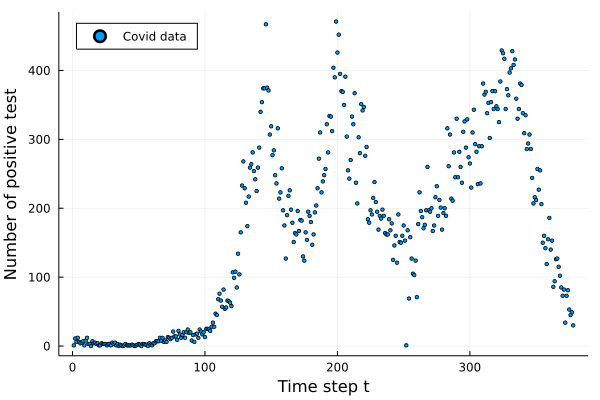

In [4]:
scatter(observation, label = "Covid data", legend = :topleft, markersize=2)
ylabel!("Number of positive test")
xlabel!("Time step t")

In [5]:
# Newtonian dynamics assumption
A = [1. 1.; 0. 1.]
B = [1. 0.]

# Priors
p_z_init = MvNormal(zeros(2),diagm(0=>ones(2)))
#p_W = Wishart(2,diagm(0=>ones(2)))
W = diagm(0=>ones(2))

# Non-conjugate loglikelihood function
function log_likelihood(y,z)
    x = exp((B*z)[1]) # B*z returns 1 dimensional array
    logpdf(Poisson(x),y)
end

log_likelihood (generic function with 1 method)

In [6]:
function approx_message_z(obs::Real,mes_income::MvNormal,η::Real,n_its::Int)
    opt = AdaMax(η) #change at this location: different optimizer
    q = mes_income # initialize variational distribution with closed form incoming message
    _, _, λ_q, _, _ = exp_family(q) # initial variational parameters
    λ_m = zeros(6) # initial message parameters
    violation = 0 # keep track of number of updates lead to invalid parameters 
    for n=1:n_its
        logp(z) = log_likelihood(obs,z)
        grad = cvi(logp,q) # grad estimates
        λ_m_old = copy(λ_m); #check convergence
        update!(opt,λ_m,λ_m - grad)
        λ_q = λ_q .+ λ_m # update variational parameters
        try
            q = exp_family(MvNormal, λ_q) # update q
            if norm(λ_m - λ_m_old) < 1e-4
                    #println("Converged in step ",n)
                    break
                end
        catch
            λ_q = λ_q .- λ_m # avoid updates that violate the support of Gaussian
            violation += 1
            @show violation
        end
    end
    return λ_m # return approximate message parameters
end

approx_message_z (generic function with 1 method)

In [7]:
#Parameters for multi-GPs
 
#1st choice (best version)
σ, l = 2, [0.1, 0.2, 0.18, 0.26, 0.14, 0.09, 5.];

eye_matrix =1* Matrix(I, 6,6); #identity matrix
A1= eye_matrix; #This choice of A's mean no correlation between output components

In [42]:
function filter_GP(W, T)
    time = []; #store time
    count_new = 0; #count the number of new added observations = number of samples needs cvi
    GP_train_size = []; #store the size of training set after updating
    uncertainty = []; #store uncertainty
    uptime = [];
    forward_estimates = Array{MvNormal}(undef, T)
    λ_m = approx_message_z(observation[1],p_z_init,0.359,15000);   
    _, _, λ_p, _, _ = exp_family(p_z_init);
    gp_input = vcat(λ_p, observation[1]); #this is our input
    gp_output = λ_m; #this is our output
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m));
    ### Collect the first 25 samples for GP
    for t=2:25
        predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        #start collecting data for Gp
         _, _, λ_pre, _, _ = exp_family(predict);
        temp = vcat(λ_pre,observation[t]); # use this variable to store new input
        gp_input = hcat(gp_input, temp); # collect new input data for GP
        
        λ_m = approx_message_z(observation[t],predict,0.359,15000);
        gp_output = hcat(gp_output,λ_m); # collect output for GP
        forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
    end
    ### Train GP
    σ_op, l_op = optim_gp_adamax(gp_input,gp_output, A1, σ, l, 1e-4,5,1000); #optimal parameters of the first output element
    ### Use GP to predict the rest
    for t=26:T
        t1 = @elapsed predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
        t2 = @elapsed _, _, λ_pre, _, _ = exp_family(predict);
        t3 = @elapsed temp = vcat(λ_pre,observation[t]); # new point

        t4 = @elapsed λ_m, var_predict = icm_predict(gp_input,gp_output,temp,A1, σ_op,l_op); #Predict
        t5 = @elapsed var_ele = diag(var_predict); # this vector stores the predictive variance of each output component
        
        if t==26
            uncertainty = append!(uncertainty,var_ele)
        else
            uncertainty = hcat(uncertainty, var_ele)
        end
        t6 = 0
        #check uncertainty, if greater than pre-defined threshold, then collect new data
        if var_ele[1] >= .8
            t7 = @elapsed λ_m = approx_message_z(observation[t],predict,0.359,15000); #use CVI
            gp_input = hcat(gp_input,temp); #observe new input
            gp_output = hcat(gp_output,λ_m); #observe new output
            count_new += 1;
            if count_new == 50 #Nnew here
                #optimal parameters of the first output element
                t6 = @elapsed σ_op, l_op = optim_gp_adamax(gp_input,gp_output, A1, σ_op, l_op, 1e-4,5,100)
                count_new = 0;
                uptime = append!(uptime,t)
            end
        else
            t7 = 0;
        end
        GP_train_size = append!(GP_train_size,size(gp_input,2))
        t8 = @elapsed forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
        time = append!(time, t1 + t2 + t3 + t4 + t5 + t6 + t7 +t8); #start from t=26
    end
    
    return forward_estimates, GP_train_size, time, uncertainty, uptime
end


filter_GP (generic function with 1 method)

In [43]:
function filter_CVI(W, T)
    time = [];
    forward_estimates = Array{MvNormal}(undef, T);
    λ_m = approx_message_z(observation[1],p_z_init,0.359,15000);   
    forward_estimates[1] = collide(p_z_init,Canonical(MvNormal, λ_m));
    for t=2:T
       t1 = @elapsed predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Matrix(Hermitian(inv(W))));
       t2 = @elapsed λ_m = approx_message_z(observation[t],predict,0.359,15000);
       t3 = @elapsed forward_estimates[t] = collide(predict,Canonical(MvNormal, λ_m));
        time = append!(time,t1+t2+t3); #start from t=2
    end
    return forward_estimates, time
end


function smooth(forward_estimates,W, T)
    smooth_estimates = Array{MvNormal}(undef, T);
    smooth_estimates[T] = forward_estimates[T];
    joint_dists = Array{MvNormal}(undef, T-1);
    for t=T-1:-1:1
        smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,W);
    end
    return smooth_estimates, joint_dists
end
;

## CVI

In [44]:
@time begin
forward_estimates_cvi, time_cvi = filter_CVI(W,T);
smooth_estimates_CVI, joint_dists_CVI = smooth(forward_estimates_cvi, W, T);
end

 77.338187 seconds (314.79 M allocations: 28.873 GiB, 8.50% gc time)


(MvNormal[FullNormal(
dim: 2
μ: [0.5484463830385768, 0.6152482035465895]
Σ: [0.3893100311585835 -0.14341103766059574; -0.14341103766059574 0.44100938176173243]
)
, FullNormal(
dim: 2
μ: [2.2428252515784, 0.15136574209994513]
Σ: [0.08181197930673229 -0.024865666968766537; -0.024865666968766537 0.4658475956814024]
)
, FullNormal(
dim: 2
μ: [1.9406417403346092, 0.14103253399703683]
Σ: [0.14228684910644773 -0.03820852880513662; -0.03820852880513662 0.4671683953750146]
)
, FullNormal(
dim: 2
μ: [2.428542561537232, -0.21616896131145752]
Σ: [0.07596561105353786 -0.01942041351921692; -0.01942041351921692 0.4693664284636394]
)
, FullNormal(
dim: 2
μ: [1.8368544489470164, -0.19785130534119383]
Σ: [0.14720859342587075 -0.03518849626398854; -0.03518849626398854 0.4751743078753702]
)
, FullNormal(
dim: 2
μ: [1.4667810562980146, -0.007311562063122112]
Σ: [0.19382061136170362 -0.04913210662052635; -0.04913210662052635 0.47713440922928696]
)
, FullNormal(
dim: 2
μ: [1.6217359832555784, 0.0209616921942

## GP

In [45]:
@time begin
forward_estimates_gp, training_size, time_gp, uncertainty, uptime = filter_GP(W,T);
smooth_estimates_GP, joint_dists_GP = smooth(forward_estimates_gp, W, T);
end

 60.012542 seconds (130.42 M allocations: 18.833 GiB, 5.98% gc time)


(MvNormal[FullNormal(
dim: 2
μ: [0.5437270104089632, 0.6165814297631509]
Σ: [0.38804034294775647 -0.1429307760474763; -0.1429307760474763 0.44076876127587133]
)
, FullNormal(
dim: 2
μ: [2.2443312591283635, 0.14914004057005292]
Σ: [0.08182516064772244 -0.024950498545253535; -0.024950498545253535 0.4654503745885248]
)
, FullNormal(
dim: 2
μ: [1.9373283770004786, 0.1378415740748926]
Σ: [0.13712224855708557 -0.0368386682108305; -0.0368386682108305 0.4667164313938034]
)
, FullNormal(
dim: 2
μ: [2.4147981471968807, -0.21308508854177716]
Σ: [0.07541210955540488 -0.01928913694108736; -0.01928913694108736 0.4690652139307304]
)
, FullNormal(
dim: 2
μ: [1.8320058713823009, -0.19430456388564438]
Σ: [0.14464680354678053 -0.034548846905652464; -0.034548846905652464 0.4750507107711457]
)
, FullNormal(
dim: 2
μ: [1.4692617379189439, -0.00708446965179893]
Σ: [0.19441283430005832 -0.04924515857515564; -0.04924515857515564 0.4771440530859519]
)
, FullNormal(
dim: 2
μ: [1.6204630062711467, 0.0218498865780

## Plot result

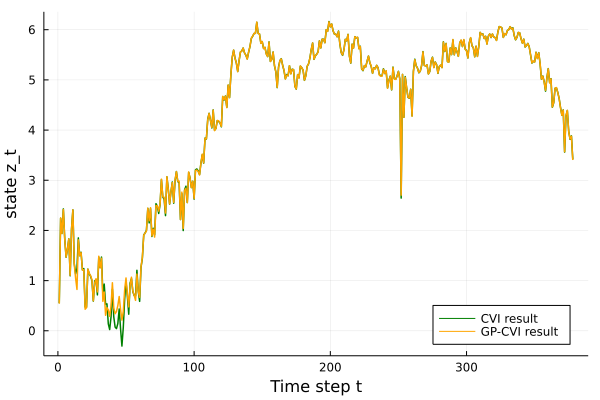

In [59]:
state1_est_GP = zeros(T)
state1_est_CVI = zeros(T)

for t=1:T
    state1_est_GP[t] = mean(smooth_estimates_GP[t])[1]
    state1_est_CVI[t] = mean(smooth_estimates_CVI[t])[1]
end

plot((state1_est_CVI),label = "CVI result", lw = 1.5, color = :green)
plot!((state1_est_GP),label = "GP-CVI result", legend = :bottomright, 
    ylabel = "state z_t", xlabel = "Time step t", lw = 1.5, color = :orange)


## Calculate FE

In [48]:
FE_cvi = []; #store FE values at each time step
for t=1:T
    if t==1
        FE_temp = -entropy(smooth_estimates_CVI[1]) + cross_entropy(smooth_estimates_CVI[1], p_z_init);
        FE_temp -= normal_conditional_entropy(smooth_estimates_CVI[t], smooth_estimates_CVI[t+1], joint_dists_CVI[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_CVI[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_cvi,FE_temp);
    elseif t==T
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_CVI[t]));
        end
        FE_temp = Av_t/500;
        append!(FE_cvi,FE_temp);
    else
        FE_temp = -normal_conditional_entropy(smooth_estimates_CVI[t], smooth_estimates_CVI[t+1], joint_dists_CVI[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_CVI[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_cvi,FE_temp);
    end
end
sum(FE_cvi)

1295.073119867711

In [49]:

FE_gp = []; #store FE values at each time step
for t=1:T
    if t==1
        FE_temp = -entropy(smooth_estimates_GP[1]) + cross_entropy(smooth_estimates_GP[1], p_z_init);
        FE_temp -= normal_conditional_entropy(smooth_estimates_GP[t], smooth_estimates_GP[t+1], joint_dists_GP[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_GP[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_gp,FE_temp);
    elseif t==T
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_GP[t]));
        end
        FE_temp = Av_t/500;
        append!(FE_gp,FE_temp);
    else
        FE_temp = -normal_conditional_entropy(smooth_estimates_GP[t], smooth_estimates_GP[t+1], joint_dists_GP[t]);
        Av_t = 0;
        for s=1:500
            Av_t -= log_likelihood(observation[t],rand(smooth_estimates_GP[t]));
        end
        FE_temp += Av_t/500;
        append!(FE_gp,FE_temp);
    end
end
sum(FE_gp)

1297.2296210394645

In [ ]:
function moving_avg(x::Array, window_size::Int)
    out = Vector{Float64}(undef,length(x)-window_size+1);
    for i=1:length(out)
        out[i] = sum(x[i:i+window_size-1])/window_size;
    end
    return out
end

In [50]:
mov_var = moving_avg(uncertainty[1,:],9)

345-element Array{Float64,1}:
 0.035240518131001056
 0.043928381088129145
 0.05554683966924875
 0.07528140642157746
 0.11143977467486514
 0.1373573821385637
 0.15211567996687847
 0.1580962117116391
 0.1672391616174979
 0.1765849704540147
 0.1932371785012739
 0.19451968762342553
 0.18884543727383651
 ⋮
 1.082021891879109
 1.0758053660321303
 1.0594688044019422
 1.0333331130177748
 1.0331489391475037
 1.3870231214464837
 1.2459430075007742
 1.2177632761706922
 1.1823141109368853
 0.8782429720388876
 0.9822727878149308
 1.0032188254528323

## Plot uncertainty

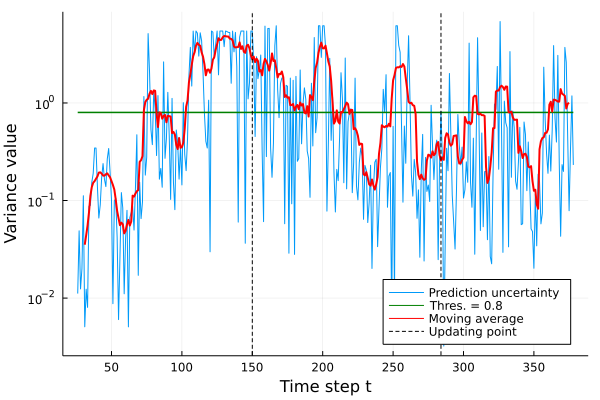

In [61]:
#plot uncertainty of 1st component
plot(26:T,uncertainty[1,:], label = "Prediction uncertainty", lw = 1, yaxis = :log10, legend = :bottomright)


plot!(26:T,0.8 .*ones(length(26:T)),lw = 1.5, color =:green,label = "Thres. = 0.8")
plot!(31:31+length(mov_var)-1, mov_var, lw=2, color = :red, label="Moving average")
plot!([uptime[1],uptime[2]],seriestype="vline", color = :black, lw = 1, ls = :dash,label = "Updating point")
ylabel!("Variance value")
xlabel!("Time step t")

In [52]:
mov_avg_time_gp = Vector{Vector{Float64}}(undef,length(uptime)+1);
mov_avg_time_cvi = Vector{Vector{Float64}}(undef,length(uptime)+1);
for i=1:length(uptime)+1
    if i==1
        mov_avg_time_gp[i] = moving_avg(time_gp[1:uptime[i]-26],19)
        mov_avg_time_cvi[i] = moving_avg(time_cvi[25:uptime[i]-2],19)
    elseif i==length(uptime)+1
        mov_avg_time_gp[i] = moving_avg(time_gp[uptime[i-1]-24:end],19)
        mov_avg_time_cvi[i] = moving_avg(time_cvi[uptime[i-1]:end],19)
    else
        mov_avg_time_gp[i] = moving_avg(time_gp[uptime[i-1]-24:uptime[i]-26],19)
        mov_avg_time_cvi[i] = moving_avg(time_cvi[uptime[i-1]:uptime[i]-2],19)
    end
end


In [53]:
mov_avgtimegp = vcat(mov_avg_time_gp...);
mov_avgtimecvi = vcat(mov_avg_time_cvi...);

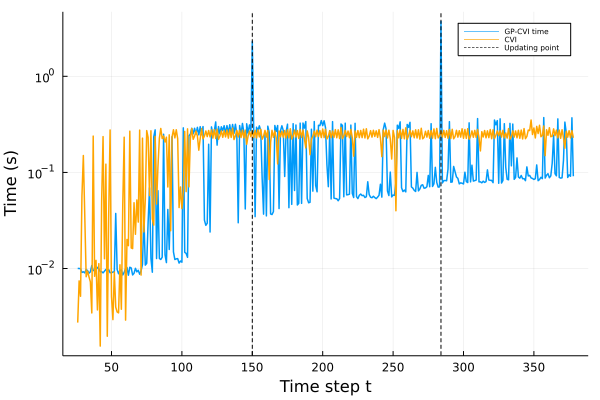

In [92]:
#Plot time
plot(26:T,time_gp, yaxis = :log10, label="GP-CVI time", linewidth = 1.5, legendfontsize=5)
plot!(26:T,time_cvi[25:end], label="CVI", color = :orange, linewidth = 1.5)
plot!([uptime[1],uptime[2]],seriestype="vline", color = :black, lw = 1, ls = :dash,label="Updating point")

xlabel!("Time step t")
ylabel!("Time (s)")

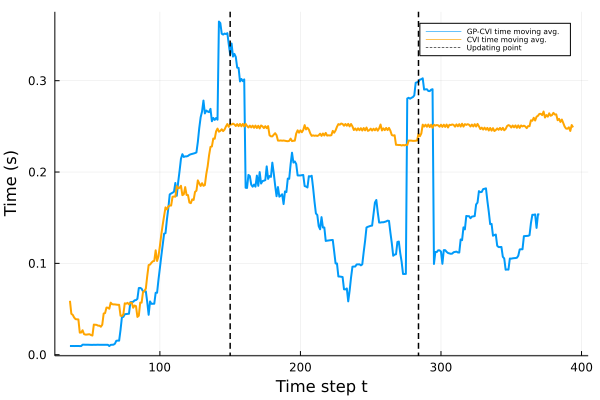

In [95]:
plot(36:36+length(moving_avg(time_gp,19))-1,moving_avg(time_gp,19), linewidth = 2, label = "GP-CVI time moving avg.", 
    legendfontsize = 5, legend = :best)
plot!(36:36+length(moving_avg(time_cvi,19))-1,moving_avg(time_cvi,19), color = :orange, linewidth = 2, label = "CVI time moving avg.")
plot!([uptime[1],uptime[2]],seriestype="vline", color = :black, lw = 1.5, ls = :dash,label="Updating point")
xlabel!("Time step t")
ylabel!("Time (s)")

In [56]:
sum(time_gp[uptime[2]+1-25:end])

12.317914097999997

In [57]:
sum(time_cvi[uptime[2]:end])

23.655022592